In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
import folium 

# Dependency between level of pollution and the temperature 

The results of analysis of dependency between pollution level (measured by concentration of Pm10) and the temperature are presented. The polynomial regression is performed to predict the pollution level based on the temperature value for every recording station available in a data set. Next, the obtained coefficients are compared between the stations and the results are presented on a map.

In the next, the results for the linear model are presented. Incresing the order does not impacted significantly the obtained results.

In [2]:
degree = 1

In [3]:
%%time 
data = pd.read_csv('/home/grzegorz/Pulpit/Projects/Airly/LDA/airly_data_full.csv')
data = data[['start_date', 'PM10', 'installation_id', 'Pressure', 'Temperature', 'air_quality_index_value']]
data.start_date = pd.to_datetime(data.start_date).reset_index(drop=True)
data = data.sort_values(by = 'start_date')
data = data.replace('None', np.nan)
dates = pd.date_range(start='2019-11-15T00:00:00Z', end='2020-01-16T23:00:00Z', freq='1H')
days = len(dates)
installations = data.installation_id.drop_duplicates().tolist()
inst = len(installations)
tmp = []
for installation in installations:
    df = {'start_date': dates, 'installation_id': np.repeat(installation, days)}
    tmp.append(pd.DataFrame(df))
tmp = pd.concat(tmp)
tmp = tmp.set_index(['start_date', 'installation_id'])
data = data.set_index(['start_date', 'installation_id'])
data = tmp.join(data, on = ['start_date', 'installation_id'], how='left')
data = data.reset_index(drop=False)
data.PM10 = data.PM10.astype(float)
data.Pressure = data.Pressure.astype(float)
data.Temperature = data.Temperature.astype(float)
data.air_quality_index_value = data.air_quality_index_value.astype(float)
tmp = []
for installation in installations:
    df = data[data.installation_id == installation]
    df = df.sort_values(by='start_date')
    df['PM10'] = df['PM10'].interpolate().interpolate(method='pad')
    df['Pressure'] = df['Pressure'].interpolate().interpolate(method='pad')
    df['Temperature'] = df['Temperature'].interpolate().interpolate(method='pad')
    df['air_quality_index_value'] = df['air_quality_index_value'].interpolate().interpolate(method='pad')
    tmp.append(df)
data = pd.concat(tmp)
ix = data.groupby('installation_id').count().sort_values(by='PM10')[data.groupby('installation_id').count().sort_values(by='PM10').PM10 > 1500].index.tolist()
data = data[data.installation_id.isin(ix)]
data = data[data.start_date > pd.to_datetime('2019-11-15T20:00:00Z')]
data = data.dropna()

CPU times: user 35.8 s, sys: 842 ms, total: 36.7 s
Wall time: 23.7 s


In [4]:
data.shape

(1324361, 6)

In [5]:
# data prepartion too
installations = data.installation_id.drop_duplicates().tolist()
count = data.groupby('installation_id').count().sort_values(by='PM10')
#count = count[count.PM10 > 100]
count = count.index.tolist()
installations = list(set(installations).intersection(set(count)))
len(installations)

876

In [6]:
polynomial_features= PolynomialFeatures(degree=degree) #define features

In [7]:
# function to fit a regression model for every installation id
def polynomial_regression(data, installation):
    tmp = data[data.installation_id == installation]
    PR = LinearRegression(n_jobs=1)
    x = polynomial_features.fit_transform(np.array(tmp.Temperature).reshape(-1, 1))
    y = tmp.PM10
    PR.fit(x, y)
    return PR.coef_, installation

In [8]:
%%time 
coeffs = []
for i in installations:
    c, _ = polynomial_regression(data, i)
    coeffs.append(c)
beta0 = [coeffs[i][0] for i in range(len(coeffs))]
beta1 = [coeffs[i][1] for i in range(len(coeffs))]
if degree == 2:
    beta2 = [coeffs[i][2] for i in range(len(coeffs))]
else:
    beta2 = [0 for i in range(len(coeffs))]

CPU times: user 11.1 s, sys: 140 ms, total: 11.3 s
Wall time: 1.88 s


In [9]:
d = {'installation_id': installations, 'beta0': beta0, 'beta1': beta1, 'beta2': beta2}
coeffs = pd.DataFrame(d)

A summary of obtained results is showned in a table below. After fitting the linear model, the intercept (beta0) for all stations turned out to be 0. The slope paramters (beta1) vary between -11.36 to 2.34. It means that for some stations the correlation of pollution level is negative with temperature (lower temperature means higher pollution level) and for some of them, the correlation is positive (higher temperature means higher pollution level). The latter is rather an unexpected result, as one can supose that lower temperature will translate to higher pollution level due to the fact, that still a siginificant part of housholds (especially outside cities) are heated using coal or gas. Based on the same reasonig, it can be expected, that the positive correlation between the temperature and pollution will be stronger outside cities. This hypothesis is werfied below. 

In [10]:
coeffs.describe()

,installation_id,beta0,beta1,beta2
count,876.000000,876.0,876.000000,876.0
mean,4771.784247,0.0,-3.188633,0.0
std,3423.544233,0.0,1.794949,0.0
min,207.000000,0.0,-11.375371,0.0
25%,2126.750000,0.0,-4.286961,0.0
50%,3362.500000,0.0,-3.015570,0.0
75%,7768.750000,0.0,-1.894088,0.0
max,10582.000000,0.0,2.339636,0.0


The scatter plot of slope coefficients for every recording station is presented with a line indicating the 0 value. Most of the values are located below the 0, however as mentioned previously, the is a couple of stations with positive slope. The estimated values do not exhibit any heterogenity constituting 1 cluster.

Text(0.5, 0, 'recording station')

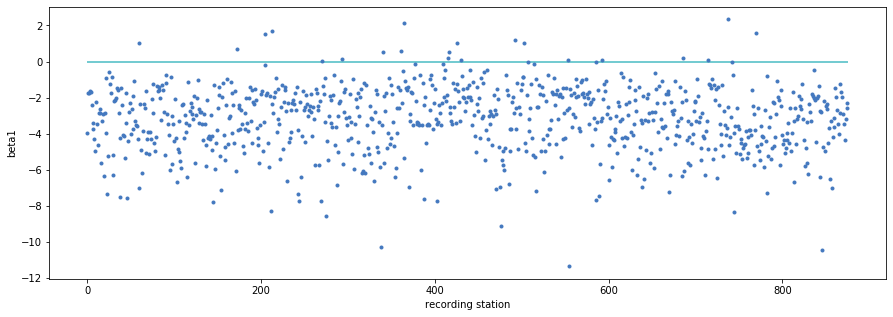

In [11]:
plt.rcParams['figure.figsize'] = 15, 5
plt.plot(coeffs.beta1, '.', c="#4378BF")
plt.hlines(y=0, xmin=0, xmax=len(coeffs.beta1), colors="#46BAC2")
plt.ylabel('beta1')
plt.xlabel('recording station')

In [12]:
installations_list = pd.read_csv('installations.csv')

In [13]:
installations_list = installations_list[['installation_id', 'elevation', 'geolocation_latitude', 'geolocation_longitude']]
installations_list = installations_list.set_index('installation_id')
installations_list = installations_list[installations_list.index.isin(installations)]

In [14]:
# scaler = MinMaxScaler()
# coeffs_cl = coeffs[coeffs.set_index('installation_id').index.isin(installations_list.index.tolist())]
# coeff_np = scaler.fit_transform(np.array(coeffs_cl.iloc[:, 1:]))
# epss = np.linspace(0.01, 0.05, 6)
# n_clusters = [i+1 for i in range(6)]

In [15]:
# clustering_dbscan = []
# clustering_kmeans = []
# for i in range(len(epss)):
#     clustering_dbscan.append(DBSCAN(eps=epss[i], min_samples=5, algorithm='brute', n_jobs=1).fit_predict(coeff_np))
#     clustering_kmeans.append(KMeans(n_clusters=n_clusters[i], n_jobs=1).fit_predict(coeff_np))

In [16]:
installations_list = coeffs.join(installations_list, on = 'installation_id', how='right')
installations_list['color'] = np.where(installations_list.beta1 >= 0, "#F05A71", "#4378BF")

In [17]:
geolocation_latitude_center = installations_list.geolocation_latitude.mean()
geolocation_longitude_center = installations_list.geolocation_longitude.mean()

The map below shows the location of stations in a neighborhood of Cracow. Blue points indicates the stations with negative corellation of pollution with remperature, whereas the red points indicate the locations with positive corellation. It can be concluded, that the correlation of pollution and temperature is rather homogenous around Cracow with couple of outliers (it is stations behaving in a different way).

In [18]:
col = ["#4378BF", "#46BAC2", "#8BDCBE", "#AE2C87", "#FFA58C", "#F05A71"]
map_PM10 = folium.Map(location=[geolocation_latitude_center,geolocation_longitude_center], zoom_start=10) 

for lat,lan, i in zip(installations_list.geolocation_latitude.tolist(), installations_list.geolocation_longitude.tolist(), installations_list.color):  
    folium.CircleMarker(location=[lat,lan],
                        radius=5,
                        weight=2,
                        color=i,
                        fill_color=i,
                        fill_opacity=0.7).add_to(map_PM10)
map_PM10